In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import pathlib
from collections import defaultdict
import os
import numpy as np
import random

In [2]:
def get_antipattern_dict(
    embedding_dir, ignore_dirs=[pathlib.Path('./embeddings/c_plus_plus/negative_samples')]
):
    antipatterns = list(embedding_dir.glob('*'))
    antipatterns_dict = {}
    for antipattern in antipatterns:
        if antipattern not in ignore_dirs:
            antipatterns_dict[antipattern.name] = list(antipattern.glob('*'))
    return antipatterns_dict

def get_labels(antipatterns_dict):
    labels = defaultdict(lambda: [False, False, False, False, ''])
    name2label = {name: i for name, i in zip(antipatterns_dict, range(len(antipatterns_dict)))}
    label2name = {value: key for key, value in name2label.items()}
    for name, paths in antipatterns_dict.items():
        for path in paths:
            labels[os.path.basename(path)][name2label[name]] = True
            labels[os.path.basename(path)][-1] = path
    return labels, name2label, label2name

def get_embedding(filename):
    return np.array([float(x) for x in filename.open().read().split()])

def get_embeddings(labels):
    for name, values in labels.items():
        labels[name].append(get_embedding(values[-1]).reshape(384, -1))
    return labels

In [3]:
import pathlib
import warnings
warnings.filterwarnings('ignore')

embedding_dir = pathlib.Path('./embeddings/c_plus_plus')
negative_samples_dir = pathlib.Path('./embeddings/c_plus_plus/negative_samples')
antipatterns_dict = get_antipattern_dict(embedding_dir)
labels, name2label, label2name = get_labels(antipatterns_dict)
_ = get_embeddings(labels)

In [4]:
negative_samples = random.sample(list(negative_samples_dir.glob('*')), 300)

In [5]:
for negative_sample in negative_samples:
    embedding = get_embedding(negative_sample).reshape(384, -1)
    labels[negative_sample.name] = [False, False, False, False, negative_sample, embedding]

In [6]:
name2label

{'parallel_inheritance_hierarchies': 0,
 'data_class': 1,
 'god_class': 2,
 'feature_envy': 3}

In [ ]:
pih = {file for file in labels.keys() if labels[file][0]}
gc = {file for file in labels.keys() if labels[file][1]}
dc = {file for file in labels.keys() if labels[file][2]}
fe = {file for file in labels.keys() if labels[file][3]}
ne = {file for file in labels.keys() if not any(labels[file][:4])}
sets = (ne, pih, gc, dc, fe)

In [ ]:
from supervenn import supervenn
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10), dpi=500)
l = ['Negative Samples', 'Parallel Inheritance Hierarchies', 'God Classes', 'Data Class', 'Feature Envy']
supervenn(sets, l, side_plots=True, widths_minmax_ratio=0.5)
plt.savefig('dataset.png')

In [13]:
len(labels)

1062

In [45]:
class PredictionHead(nn.Module):
    def __init__(self, embedding_dim, conv_out_dim, lstm_hidden, n_labels, filter_size=3, drop_rate_conv=0.3, drop_rate_lstm=0.5):
        super(PredictionHead, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(embedding_dim,
                      conv_out_dim,
                      filter_size,
                      padding=filter_size // 2
                     ),
            nn.ReLU(),
            nn.Dropout(drop_rate_conv)
        )
        self.biLSTM = nn.LSTM(
            input_size=conv_out_dim,
            hidden_size=lstm_hidden,
            bidirectional=True,
            batch_first=True
        )    
        self.out = nn.Linear(2*lstm_hidden, n_labels)
        self.dropout = nn.Dropout(drop_rate_lstm)
        
        print(embedding_dim)
        print(conv_out_dim)
        print(lstm_hidden)
        print(n_labels)
        
    def forward(self, x):
        # Input: Tensor([batch_size, embedding_dim, max_seq])
        print(x.shape)
        # Expected: Tensor([batch_size, conv_out_dim, max_seq])
        x = self.conv(x)
        print(x.shape)
        x = self.dropout(x)
        print(x.shape)
        
        # Expected: Tensor([batch_size, max_seq, conv_out_dim])
        x = x.permute(0, 2, 1)
        print(x.shape)
        
        # Expected: Tensor([batch_size, max_seq, 2*hidden_size])
        outputs, (hn, cn) = self.biLSTM(x)
        print(hn[0].shape, hn[1].shape)
        cat = torch.cat([hn[0], hn[1]], dim=-1)
        print(cat.shape)
        res = self.out(self.dropout(cat))
        print(res.shape)
        
        raise Exception
        return res

In [19]:
class EmbeddingDataset(Dataset):
    def __init__(self, labels, names):
        self.labels = labels
        self.names = sorted(names, key=lambda x: self.labels[x][-1].shape[1])
        
    def __getitem__(self, idx):
        *labels, _, emb = self.labels[self.names[idx]]
        return torch.FloatTensor(emb), np.array(labels).astype(int)
    
    def __len__(self):
        return len(self.names)

In [20]:
labels = {key:value for key, value in labels.items() if value != [False, False, '']}

In [21]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(list(labels.keys()), test_size=0.2, random_state=42)

In [22]:
def collate_fn(batch):
    max_sequence_len = max([x[0].shape[1] for x in batch])
    emb_dim = batch[0][0].shape[0]
    sequence_padded = torch.zeros([len(batch), emb_dim, max_sequence_len])
    ys = []
    for i, (X, y) in enumerate(batch):
        sequence_padded[i,:,:X.shape[-1]] = X
        ys.append(y)
    return sequence_padded, torch.Tensor(ys)

In [23]:
from sklearn.metrics import roc_curve
import numpy as np


def get_thresholds_multiclass(predictions, target):
    thresholds = []
    for i in range(predictions.shape[1]):
        fpr, tpr, threshes = roc_curve(target.T[i], predictions.T[i])
        # calculate the g-mean for each threshold
        gmeans = np.sqrt(tpr * (1 - fpr))
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)
        thresholds.append(threshes[ix])
    return thresholds


# Requires two tensors of size [batch_size, n_classes] and a vector of size [n_classes]
def get_accuracy_multiclass(predictions, target, thresholds=None):
    if thresholds is None:
        thresholds = get_thresholds_multiclass(predictions, target)
    predictions = predictions.T
    target = target.T
    correct = 0
    for i in range(predictions.shape[0]):
        predictions[i] = predictions[i] > thresholds[i]
        correct += np.sum(predictions[i] == target[i])
    return thresholds, correct / (predictions.shape[0] * predictions.shape[1])

In [24]:
def train_step_with_roc(model, train_loader, loss_func, optimizer, device, thresholds):
    model.train()
    losses_train = []
    pbar = tqdm(train_loader)
    preds, lbls = [], []
    for X, y in pbar:
        model.zero_grad()
        lbls.append(y)
        X, y = X.to(device), y.to(device)

        out = model(X)
        preds.append(torch.sigmoid(out).cpu().detach().numpy())
        loss = loss_func(out, y)
        loss.backward()
        optimizer.step()
        # compute metrics
        losses_train.append(loss.item())
        _, acc = get_accuracy_multiclass(np.vstack(preds), np.vstack(lbls), thresholds)
        pbar.set_description(
            f'TRAIN. Mean Loss [{np.mean(losses_train):.2f}]. Accuracy [{acc:.2f}]')
    return losses_train

In [25]:
def train_step(model, train_loader, loss_func, optimizer, device):
    model.train()
    losses_train = []
    correct = 0
    total = 0
    pbar = tqdm(train_loader)
    for X, y in pbar:
        model.zero_grad()
        X, y = X.to(device), y.to(device)
        out = model(X)
        loss = loss_func(out, y)
        loss.backward()
        optimizer.step()

        # make predictions
        y = y.reshape(-1).cpu().numpy()
        preds = (torch.sigmoid(out) > 0.5).reshape(-1).detach().cpu().numpy().astype(int)

        # compute metrics
        cur_correct = np.sum(preds == y)
        correct += cur_correct
        total += len(y)
        
        losses_train.append(loss.item())
        pbar.set_description(
            f'TRAIN. Mean Loss [{np.mean(losses_train):.2f}]. Mean Accuracy [{correct / total:.2f}]')
    return losses_train

In [26]:
def valid_step(model, valid_loader, loss_func, device):
    losses_valid = []
    correct = 0
    total = 0
    model.eval()
    pbar = tqdm(valid_loader)
    total_preds = []
    total_lbls = []
    for X, y in pbar:
        X, y = X.to(device), y.to(device)
        out = model(X)

        loss = loss_func(out, y)
        # make predictions
        preds = (torch.sigmoid(out) > 0.5).reshape(-1).detach().cpu().numpy().astype(int)
        total_preds.append((torch.sigmoid(out) > 0.5).detach().cpu().numpy().astype(int))
        total_lbls.append(y.cpu().numpy())
    
        # compute metrics
        y = y.reshape(-1).cpu().numpy()
        cur_correct = np.sum(preds == y)
        correct += cur_correct
        total += len(y)

        losses_valid.append(loss.item())
        pbar.set_description(
            f'VALID. Mean Loss [{np.mean(losses_valid):.2f}]. Mean Accuracy [{correct / total:.2f}]')
    print(classification_report(np.vstack(total_lbls), np.vstack(total_preds)))
    return losses_valid

In [29]:
from sklearn.metrics import classification_report, f1_score
def valid_step_with_roc(model, train_loader, loss_func, device):
    losses_valid = []
    model.eval()
    pbar = tqdm(train_loader)
    preds, lbls = [], []
    for X, y in pbar:
        lbls.append(y)
        X, y = X.to(device), y.to(device)

        out = model(X)
        preds.append(torch.sigmoid(out).cpu().detach().numpy())
        loss = loss_func(out, y)

        # compute metrics
        losses_valid.append(loss.item())
        _, acc = get_accuracy_multiclass(np.vstack(preds), np.vstack(lbls))
        pbar.set_description(
            f'VALID. Mean Loss [{np.mean(losses_valid):.2f}]. Accuracy [{acc:.2f}]')
    preds = np.vstack(preds)
    thresholds, _ = get_accuracy_multiclass(preds, np.vstack(lbls))
    print(classification_report(np.vstack(lbls), preds))
    return losses_valid, thresholds

In [28]:
batch_size = 16
train_dataset = EmbeddingDataset(labels, train)
valid_dataset = EmbeddingDataset(labels, test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
embedding_dim = 384
conv_out_dim = 128
lstm_hidden = 128
n_labels = len(name2label)

lr = 1e-4
epochs = 16
loss_func = nn.BCEWithLogitsLoss()
thresholds = np.repeat(0.5, n_labels)

In [46]:
model = PredictionHead(embedding_dim, conv_out_dim, lstm_hidden, n_labels)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

384
128
128
4


In [32]:
name2label

{'parallel_inheritance_hierarchies': 0,
 'data_class': 1,
 'god_class': 2,
 'feature_envy': 3}

In [47]:
from tqdm.notebook import tqdm
valid_means = []
train_means = []
for epoch in range(epochs):
    losses_train = train_step(model, train_loader, loss_func, optimizer, device)
    losses_valid = valid_step(model, valid_loader, loss_func, device)
    valid_means.append(np.mean(losses_valid))
    train_means.append(np.mean(losses_train))

plt.plot(valid_means)
plt.plot(train_means)
plt.legend(["Validation loss", "Training loss"], loc="upper left")
plt.show()

  0%|          | 0/54 [00:00<?, ?it/s]

torch.Size([16, 384, 2])
torch.Size([16, 128, 2])
torch.Size([16, 128, 2])
torch.Size([16, 2, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 256])
torch.Size([16, 4])


Exception: 

In [ ]:
plt.plot(valid_means)
plt.plot(train_means)
plt.legend(["Validation loss", "Training loss"], loc="upper left")
plt.xticks(list(range(epochs)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('python-lstm-14-epochs.png', dpi=300)
plt.show()

In [26]:
model = PredictionHead(embedding_dim, conv_out_dim, lstm_hidden, n_labels)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

In [27]:
thresholds

array([0.5, 0.5, 0.5, 0.5])

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.04      0.50      0.07         2
           1       0.69      0.61      0.65       127
           2       0.00      0.00      0.00         1
           3       0.29      0.67      0.40        51

   micro avg       0.28      0.62      0.39       181
   macro avg       0.25      0.44      0.28       181
weighted avg       0.57      0.62      0.57       181
 samples avg       0.29      0.46      0.33       181



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.04      0.50      0.08         2
           1       0.73      0.64      0.68       127
           2       0.00      0.00      0.00         1
           3       0.30      0.57      0.39        51

   micro avg       0.31      0.61      0.41       181
   macro avg       0.27      0.43      0.29       181
weighted avg       0.60      0.61      0.59       181
 samples avg       0.29      0.46      0.34       181



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.04      0.50      0.07         2
           1       0.71      0.65      0.67       127
           2       0.00      0.00      0.00         1
           3       0.30      0.61      0.41        51

   micro avg       0.31      0.63      0.42       181
   macro avg       0.26      0.44      0.29       181
weighted avg       0.58      0.63      0.59       181
 samples avg       0.31      0.46      0.35       181



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.03      0.50      0.05         2
           1       0.73      0.62      0.67       127
           2       0.00      0.00      0.00         1
           3       0.27      0.49      0.35        51

   micro avg       0.29      0.58      0.38       181
   macro avg       0.26      0.40      0.27       181
weighted avg       0.59      0.58      0.57       181
 samples avg       0.29      0.43      0.32       181



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.03      0.50      0.05         2
           1       0.71      0.69      0.70       127
           2       0.00      0.00      0.00         1
           3       0.29      0.47      0.36        51

   micro avg       0.30      0.62      0.40       181
   macro avg       0.26      0.42      0.28       181
weighted avg       0.58      0.62      0.59       181
 samples avg       0.31      0.46      0.35       181



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.03      0.50      0.06         2
           1       0.71      0.54      0.61       127
           2       0.00      0.00      0.00         1
           3       0.30      0.65      0.41        51

   micro avg       0.28      0.56      0.37       181
   macro avg       0.26      0.42      0.27       181
weighted avg       0.58      0.56      0.54       181
 samples avg       0.28      0.42      0.32       181



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.03      0.50      0.05         2
           1       0.70      0.57      0.63       127
           2       0.00      0.00      0.00         1
           3       0.32      0.43      0.37        51

   micro avg       0.28      0.53      0.37       181
   macro avg       0.26      0.38      0.26       181
weighted avg       0.58      0.53      0.55       181
 samples avg       0.26      0.39      0.30       181



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.03      0.50      0.06         2
           1       0.68      0.59      0.63       127
           2       0.00      0.00      0.00         1
           3       0.27      0.57      0.36        51

   micro avg       0.28      0.58      0.38       181
   macro avg       0.25      0.41      0.26       181
weighted avg       0.55      0.58      0.55       181
 samples avg       0.28      0.43      0.32       181



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.02      0.50      0.05         2
           1       0.70      0.63      0.66       127
           2       0.00      0.00      0.00         1
           3       0.27      0.63      0.38        51

   micro avg       0.28      0.62      0.39       181
   macro avg       0.25      0.44      0.27       181
weighted avg       0.57      0.62      0.57       181
 samples avg       0.28      0.46      0.33       181



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.02      0.50      0.03         2
           1       0.72      0.54      0.62       127
           2       0.00      0.00      0.00         1
           3       0.29      0.55      0.38        51

   micro avg       0.30      0.54      0.39       181
   macro avg       0.26      0.40      0.26       181
weighted avg       0.59      0.54      0.54       181
 samples avg       0.28      0.39      0.31       181



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.01      0.50      0.02         2
           1       0.67      0.63      0.65       127
           2       0.00      0.00      0.00         1
           3       0.28      0.45      0.35        51

   micro avg       0.25      0.57      0.34       181
   macro avg       0.24      0.40      0.26       181
weighted avg       0.55      0.57      0.55       181
 samples avg       0.29      0.43      0.32       181



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.02      0.50      0.03         2
           1       0.72      0.61      0.66       127
           2       0.00      0.00      0.00         1
           3       0.29      0.53      0.38        51

   micro avg       0.26      0.58      0.36       181
   macro avg       0.26      0.41      0.27       181
weighted avg       0.59      0.58      0.57       181
 samples avg       0.27      0.43      0.31       181



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.02      0.50      0.03         2
           1       0.72      0.57      0.63       127
           2       0.00      0.00      0.00         1
           3       0.30      0.61      0.41        51

   micro avg       0.25      0.57      0.35       181
   macro avg       0.26      0.42      0.27       181
weighted avg       0.59      0.57      0.56       181
 samples avg       0.26      0.43      0.30       181



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.02      0.50      0.04         2
           1       0.72      0.61      0.66       127
           2       0.00      0.00      0.00         1
           3       0.32      0.49      0.39        51

   micro avg       0.28      0.57      0.38       181
   macro avg       0.26      0.40      0.27       181
weighted avg       0.59      0.57      0.57       181
 samples avg       0.29      0.43      0.32       181



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.02      0.50      0.04         2
           1       0.72      0.63      0.67       127
           2       0.00      0.00      0.00         1
           3       0.30      0.59      0.39        51

   micro avg       0.26      0.61      0.37       181
   macro avg       0.26      0.43      0.28       181
weighted avg       0.59      0.61      0.58       181
 samples avg       0.29      0.46      0.33       181



  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.02      0.50      0.04         2
           1       0.71      0.64      0.67       127
           2       0.00      0.00      0.00         1
           3       0.30      0.61      0.40        51

   micro avg       0.27      0.62      0.38       181
   macro avg       0.26      0.44      0.28       181
weighted avg       0.58      0.62      0.59       181
 samples avg       0.29      0.47      0.34       181



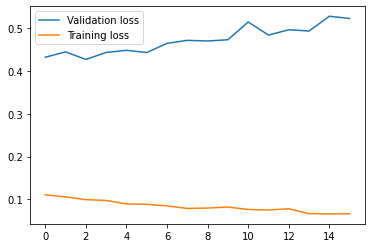

In [30]:
from tqdm.notebook import tqdm
valid_means = []
train_means = []
for epoch in range(epochs):
    losses_train = train_step_with_roc(model, train_loader, loss_func, optimizer, device, thresholds)
    losses_valid, thresholds  = valid_step_with_roc(model, valid_loader, loss_func, device)
    valid_means.append(np.mean(losses_valid))
    train_means.append(np.mean(losses_train))

plt.plot(valid_means)
plt.plot(train_means)
plt.legend(["Validation loss", "Training loss"], loc="upper left")
plt.show()

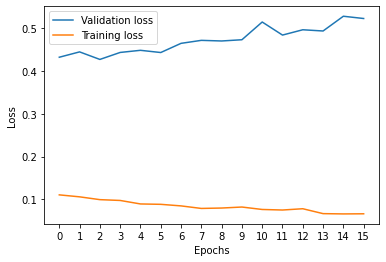

In [31]:
plt.plot(valid_means)
plt.plot(train_means)
plt.legend(["Validation loss", "Training loss"], loc="upper left")
plt.xticks(list(range(epochs)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('cplusplus_lstm-16-epochs_with_roc_curve.png', dpi=300)
plt.show()